<h1 style="text-align: center">Scientific Programming with Python</h1>

<h3 style="text-align: center">Christian Hill</h3>

<h4 style="text-align: center">Michaelmas Term 2016</h4>

## Assessment Exercise: Powder diffraction patterns

The relative integrated intensity of the $hkl$ X-ray reflection by a powdered crystalline sample as a function of angle, $\theta$, may be written
$$
I(\theta) = \frac{p}{V^2}\left[ \frac{1+\cos^2 2\theta}{\sin^2\theta\cos\theta}\right]|F_{hkl}|^2\exp\left(-\frac{2B\sin^2\theta}{\lambda^2}\right), \quad\quad\quad\mathrm{(1)}
$$
where:

* $\theta$ is the _Bragg angle_, given by $2d\sin\theta = \lambda$ for X-ray wavelength $\lambda$ and $hkl$ interplanar spacing, $d$;
* $|F_{hkl}|$ is the magnitude of the structure factor;
* $p$ is the multiplicity of the $hkl$ reflection;
* $V$ is the unit cell volume;
* $B$ is the isotropic temperature factor.

In this exercise we will simulate a powder diffraction pattern. The cell parameters, $a$, $b$, $c$, $\alpha$, $\beta$, $\gamma$, and list of $hkl$ values contributing to the reflections and their multiplicities will be provided. We will assume $B$ is a constant for all reflections.

In [18]:
# Some imports that will prove useful
import numpy as np
import checks

---

### Question 1
Write a function, `calc_V` calculating the volume of the crystal unit cell,
$$
V = abc\sqrt{1 - \cos^2\alpha - \cos^2\beta - \cos^2\gamma + 2\cos\alpha\cos\beta\cos\gamma}
$$


In [19]:
def calc_V(a, b, c, alpha, beta, gamma):
    """Calculate and return the unit cell volume.
    
    a, b, c are the cell edge dimensions
    alpha, beta, gamma are the cell angles in radians.
    
    """
    #calculating edge length contribution
    edge_V = a*b*c
    #calculating contribution from angles
    angle_V = np.sqrt(1 - np.cos(alpha)**2 - np.cos(beta)**2 - np.cos(gamma)**2 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma))
    #calculating total volume
    V = edge_V * angle_V
    
    return V

Test your code by running the following cell

In [20]:
checks.run_check('check_V', calc_V, hint=True)

**<span style="color: green;">PASSED</span>**

---

### Question 2

The _scattering vector_, $\boldsymbol{q}$, has magnitude
$$
q = \frac{4\pi\sin\theta}{\lambda} = \frac{2\pi}{d}
$$
where the interplanar spacing (the $d$-_spacing_) is given by
$$
\frac{1}{d^2} = \frac{1}{V^2}(S_{11}h^2 + S_{22}k^2 + S_{33}l^2 + 2S_{12}hk + 2S_{23}kl + 2S_{13}{hl}).
$$
In this equation,
$$
\begin{align}
S_{11} &= b^2c^2\sin^2\alpha\\
S_{22} &= a^2c^2\sin^2\beta\\
S_{33} &= a^2b^2\sin^2\gamma\\
S_{12} &= abc^2(\cos\alpha\cos\beta - \cos\gamma)\\
S_{23} &= a^2bc(\cos\beta\cos\gamma - \cos\alpha)\\
S_{13} &= ab^2c(\cos\gamma\cos\alpha - \cos\beta)
\end{align}
$$

Write a function, `calc_q` which returns $|q|$ for a given $hkl$ reflection.

In [21]:
def calc_q(h, k, l):
    """Calculate and return the magnitude of the scattering vector, q.
    
    |q| is calculated for the reflection indexed at (h,k,l).
    The cell parameters: a, b, c, alpha, beta, gamma are to be
    resolved in the containing scope.
    
    """
    #Calculate Volume with calc_V function
    V = calc_V(a, b, c, alpha, beta, gamma)
    # Calculate the S values
    S_11 = b**2 * c**2 * np.sin(alpha)**2
    S_22 = a**2 * c**2 * np.sin(beta)**2
    S_33 = a**2 * b**2 * np.sin(gamma)**2
    S_12 = a*b*c**2 * (np.cos(alpha)*np.cos(beta)-np.cos(gamma))
    S_23 = a**2*b*c * (np.cos(gamma)*np.cos(beta)-np.cos(alpha))
    S_13 = a*b**2*c * (np.cos(alpha)*np.cos(gamma)-np.cos(beta))
    #calculate d^-2
    d_to_minus2 = V**-2*(S_11*h**2 + S_22*k**2 + S_33*l**2 + 2*S_12*h*k + 2*S_23*k*l + 2*S_13*h*l)
    d = np.sqrt(d_to_minus2**-1)
    q = (2*np.pi)/d

    return q

Test your code by running the following cell

In [22]:
checks.run_check('check_q', calc_q, hint=True)

**<span style="color: green;">PASSED</span>**

---

The structure factor, $F_{hkl}$, is calculated as
$$
F_{hkl} = \sum_{i=1}^{N} f_i \exp[2\pi i (hx_i + ky_i + lz_i)]
$$
where $N$ is the number of atoms in the unit cell, $(x_i, y_i, z_i)$ is the position of atom $i$, and $f_i$ is the _atomic form factor_ for atom $i$ (which depends on the atom type and the magnitude of the scattering vector, $q$).

The atomic form factor may be described by the formula
$$
f_i(q) = \sum_{j=1}^4 a_j \exp\left[-b_j\left(\frac{q}{4\pi}\right)^2\right] + c,
$$
where $a_j$, $b_j$, and $c$ are coefficients tabulated in the comma-separated file [`form-factors.csv`](form-factors.csv) for 211 atoms and ions and the magnitude of the scattering vector, $q$ is in $\mathrm{nm^{-1}}$.

### Question 3

Write a function which reads in this file to a dictionary, keyed by the the atom or ion symbol as given in the first column. The "value" associated with each key should be a numpy array of the nine coefficients $a_1, b_1, a_2, b_2, a_3, b_3, a_4, b_4, c$

In [23]:
def read_form_factor_coefs():
    """Read in the atomic form factor coefficients from form-factors.csv.
    
    The nine coefficients are returned in a dictionary, keyed by the atom
    or ion symbol.
    
    """
    coeffs = {}                                           #creating empty dictionary
    import csv                                            #importing csv library
    with open('form-factors.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)                      #creating csv.reader object from form-factors.csv
        for row in reader:                                #reading each row into a dictionary, with a numpy array key
            coeffs[row[0]] = np.array([row[1],row[2],row[3],row[4],row[5],row[6],row[7],row[8],row[9]], dtype =float)
    return coeffs

Test your code by running the following cell

In [24]:
checks.run_check('check_f_coefs', read_form_factor_coefs)

**<span style="color: green;">PASSED</span>**

### Question 4

Now write a function, `calc_f` to calculate the atomic form factor for an atom or ion given its symbol and the magnitude of the scattering vector, $q$.


In [25]:
# Read in the coefficients for the atomic form factors
coeffs = read_form_factor_coefs()

def calc_f(symbol, q, coeffs=coeffs):
    """Calculate and return the atomic form factor.
    
    symbol is a string identifying the atom or ion (e.g. 'Zn', 'Mg+2')
    q is the magnitude of the scattering vector in reciprocal nm.
    
    """
    coefs = coeffs[symbol]
    f=0
    for n in range(4):
        f += coefs[2*n] * np.exp(-1*coefs[2*n+1]*(q/(4*np.pi))**2)
    f += coefs[8]

    return f

Test your code by running the following cell

In [26]:
checks.run_check('check_form_factor', calc_f, hint=True)

**<span style="color: green;">PASSED</span>**

### Question 5

Write a function, `calc_F`, to calculate the magnitude of the structure factor for an $hkl$ reflection, $|F_{hkl}|$. Assume that the atom positions are provided in a list of $N$ tuples: each tuple represents an atom in the unit cell with the first item that atom's symbol and the second a 3-tuple of that atom's fractional coordinates. For example, the atom positions in zinc blende (ZnS) would be represented by

    atoms = [( 'Zn', (0.25, 0.25, 0.25) ),
             ( 'Zn', (0.75, 0.75, 0.25) ),
             ( 'Zn', (0.75, 0.25, 0.75) ),
             ( 'Zn', (0.25, 0.75, 0.75) ),
             ( 'S', (0.0, 0.0, 0.0) ),
             ( 'S', (0.5, 0.5, 0.0) ),
             ( 'S', (0.5, 0.0, 0.5) ),
             ( 'S', (0.0, 0.5, 0.5) ),
            ]

In [27]:
def calc_absF(hkl, atoms, q=None):
    """Return the magnitude of the structure factor for the hkl reflection.
    
    hkl is a NumPy array of (h, k, l)
    atoms is a list of (atom_symbol, atom_position) tuples where atom_symbol
    identifies the atom or ion and atom_position is its fractional coordinates
    in the unit cell.
    q is the magnitude of the scattering vector for the hkl reflection: if it
    is not provided, it will be calculated.
    
    """
    #calculate q if required
    if q is None:
        q = calc_q(*hkl)
    else:
        pass
    #initialise F to zero
    F = 0
    #for each atom in cell
    for n in range(len(atoms)):
        f = calc_f(atoms[n][0], q)                                        #calculate atomic form factor f
        coord_plane = np.multiply(atoms[n][1],hkl)                        #multiply coordinates by plane indices
        exponent = 2* np.sum(coord_plane)                                 #calculate the exponent of e^i*pi
        F += f * (np.cos(exponent * np.pi) + 1j* np.sin(exponent*np.pi))  #add this atom contribution to F
    
    #get absolute value of F
    absF = abs(F)
    return absF

Test your code by running the following cell

In [28]:
checks.run_check('check_structure_factor', calc_absF, hint=True)

**<span style="color: green;">PASSED</span>**

---

### Question 6

Now write a function, `calc_I` to calculate the relative integrated intensity of an X-ray reflection $hkl$ with multiplicity $p$ using equation (1). Take $B = 0$ (that is, ignore temperature effects) and $\lambda = 0.154\;\mathrm{nm}$ (the Cu $\mathrm{K}_\alpha$ line). Your code should return `thetaB`, the Bragg angle corresponding to the $hkl$ reflection, and `I`, the reflected intensity at that angle.

In [29]:
def calc_I(hkl, p, B=0, lam=0.154):
    """Return the Bragg angle and integrated intensity of reflection hkl.
    
    hkl is a NumPy array of (h, k, l)
    p is the multiplicity of the reflection.
    B is the Isotropic temperature factor in nm2.
    lam is the X-ray wavelength in nm.
    
    Returns:
    thetaB: the Bragg angle for the reflection hkl.
    I: the relative integrated intensity of reflection hkl.
    
    """
    V = calc_V(a, b, c, alpha, beta, gamma) #assume cell parameters are resolved in containing scope
    q = calc_q(*hkl)
    sin_theta = q*lam/(4*np.pi)
    thetaB = np.arcsin(sin_theta)
    absF = calc_absF(hkl, atoms, q)
    geom_I = (1 + np.cos(2*thetaB)**2)/(np.sin(thetaB)**2 * np.cos(thetaB))
    structure_I = absF**2
    thermal_I = np.exp((-2*B*np.sin(thetaB)**2)/lam**2)
    I = (p/(V**2)) * geom_I * structure_I * thermal_I
    
    return thetaB, I

Test your code by running the following cell

In [30]:
checks.run_check('check_intensity_calculation', calc_I, hint=True)

**<span style="color: green;">PASSED</span>**

### Question 7

Now let's simultate a powder diffraction pattern. First execute the cell below to import the crystallographic data relating to the zinc blende structure of ZnS.

In [31]:
from ZnS import cellparams, atoms, reflections
a, b, c, alpha, beta, gamma = cellparams

`reflections` is a list of `( (hkl), p )` tuples where `p` is the multiplicity of the `hkl` reflection. Use your function, `calc_I`, to calculate a list of Bragg angles, `thetaB`, and reflection intensities, `I`. Normalize the intensities so that the maximum intensity is 100.

In [36]:
#initiate empty arrays
thetaB = []
I = []
#reading reflections data and calculating angles and intensities
for n in range(len(reflections)):
    hkl = reflections[n][0]
    p = reflections[n][1]
    theta_I = calc_I(hkl,p)
    thetaB.append(theta_I[0])
    I.append(theta_I[1])

#normalise intensities
max_I = max(I)
for n in range(len(I)):
    I[n] *= (100/max_I)
    
print(I)
print(thetaB)

[100.0, 15.94184377673218, 24.28483836537568, 11.892332640731624, 0.629266451876869, 2.20518373320162, 3.409962908448351, 0.33281142846551826, 4.790040466670706, 2.3228630880736603, 2.2485826901274435, 5.055406987639182, 6.176856017438328, 4.055997924835849]
[0.24908891447053622, 0.2886496922412651, 0.414319676235901, 0.4916169463579423, 0.5155830497176904, 0.6056737176655842, 0.6692498344656206, 0.6899708877816099, 0.7715776042673488, 0.8324213011349311, 0.935902250463164, 1.0010351721192636, 1.1201545422741592, 1.2035339042911954]


### Plotting the simulated pattern

Run the following code to plot a simulated powder diffraction pattern from the arrays `thetaB` and `I`

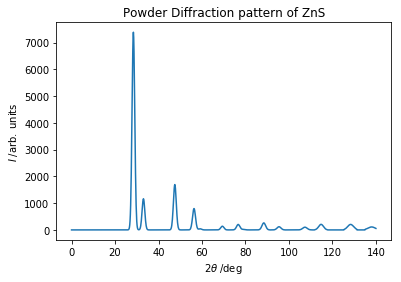

In [37]:
import matplotlib.pyplot as plt

# Some settings to improve the look of the figure: while testing, comment out
# these three lines to speed up the time it takes to render the plot.

def gaussian(x, x0, sigma):
    """The normalized Gaussian function centred at x0 with standard deviation sigma."""
    
    return np.exp(-((x-x0)/sigma)**2 / 2) / sigma / np.sqrt(2*np.pi)

# Total number of points in the spectrum.
n = 1000
# Maximum theta (radians)
theta_max = np.radians(70)
# The grid of angles, theta, and the grid spacing, dtheta.
theta_grid, dtheta = np.linspace(0, theta_max, n, retstep=True)
# Each reflection is calculated as a Gaussian function out to nwidth
# standard deviations (width, in rad).
width, nwidths = np.pi / 600, 5
# The width of the Gaussian in integer index units
h = int(nwidths * width / dtheta)

spec = np.zeros(n)
for theta, intensity in zip(thetaB, I):
    idx = int(n * theta/theta_max)
    # This reflection's contribution to the spectrum: the width varies with
    # as 1 / cos(theta).
    spec[idx-h:idx+h] += intensity * gaussian(theta_grid[idx-h:idx+h], theta_grid[idx],
                                              width / np.cos(theta))

# Make and label the plot.
plt.plot(np.degrees(2*theta_grid), spec)
plt.xlabel(r'$2\theta\;/\mathrm{deg}$')
plt.ylabel(r'$I\;/\mathrm{arb.\;units}$')
plt.title('Powder Diffraction pattern of ZnS')
plt.show()